In [1]:
#Importing libraries
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import cv2
import gc
import PIL.Image as Image
import tifffile as tiff
from pathlib import Path
from tqdm.notebook import tqdm 

#Importing ML Tools
import tensorflow as tf
from tensorflow import keras
print("Tensorflow Version Installed: " + tf.__version__)

physical_devices = tf.config.list_physical_devices('GPU')
for device in physical_devices:
    tf.config.experimental.set_memory_growth(device, True)

!nvidia-smi

print("\nSetup Complete")

Tensorflow Version Installed: 2.10.0
Sat Apr  8 09:02:04 2023       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 527.27       Driver Version: 527.27       CUDA Version: 12.0     |
|-------------------------------+----------------------+----------------------+
| GPU  Name            TCC/WDDM | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Quadro RTX 3000    WDDM  | 00000000:01:00.0 Off |                  N/A |
| N/A   67C    P8     7W /  N/A |     14MiB /  6144MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                   

In [2]:
OUTPUT_PNG = True
OUTPUT_NPY = False

ROI_SIZE = 1024
IMAGE_NUM = 3

INPUT_DIR = Path("kaggle/input/vesuvius-challenge-ink-detection/train")
OUTPUT_DIR = Path("kaggle/working")

In [3]:
def crop_image(image_id, input_dir, output_dir):

    output_data_dir = Path(output_dir / f"{image_id}")
    if not output_data_dir.exists():
        output_data_dir.mkdir()

    # Load label image
    inklabels_img = np.array(Image.open(str(input_dir / f"{image_id}" / "inklabels.png")))
    inklabels_img = np.pad(inklabels_img, [(0, ROI_SIZE-inklabels_img.shape[0]%ROI_SIZE), (0, ROI_SIZE-inklabels_img.shape[1]%ROI_SIZE)], 'constant')

    # Get the scanning position of the image
    x_pos_list = []
    y_pos_list = []
    for y in range(0, inklabels_img.shape[0], ROI_SIZE):
        for x in range(0, inklabels_img.shape[1], ROI_SIZE):
            if inklabels_img[y:y+ROI_SIZE, x:x+ROI_SIZE].max() > 0:
                x_pos_list.append(x)
                y_pos_list.append(y)

    # Crop the image
    image_path_list = sorted(list(Path(input_dir / f"{image_id}" / "surface_volume").glob('*.tif')))
    for i, image_path in tqdm(enumerate(image_path_list), total=len(image_path_list), desc=f"Cropping images - {image_id}", dynamic_ncols=True):

        # load image
        img = tiff.imread(str(image_path))
        img = np.pad(img, [(0, ROI_SIZE-img.shape[0]%ROI_SIZE), (0, ROI_SIZE-img.shape[1]%ROI_SIZE)], 'constant')

        # crop
        for j, (x, y) in enumerate(zip(x_pos_list, y_pos_list)):

            image_roi = img[y:y+ROI_SIZE, x:x+ROI_SIZE]
            image_roi = image_roi.astype(np.float32) / 65535.0

            if OUTPUT_NPY:
                np.save(str(output_data_dir / f"{j:03d}_{i:02d}"), image_roi)

            if OUTPUT_PNG:
                output_image_dir = Path(output_data_dir / f"{j:03d}")
                if not output_image_dir.exists():
                    output_image_dir.mkdir()
                cv2.imwrite(str(output_image_dir / f"{i:02d}.png"), (image_roi * 255).astype(np.uint8))

        del img
        gc.collect()

    # Create training data
    image_id_list = []
    roi_id_list = []
    for j, (x, y) in tqdm(enumerate(zip(x_pos_list, y_pos_list)), total=len(x_pos_list), desc=f"Merge images - {image_id}", dynamic_ncols=True):

        # input
        if OUTPUT_NPY:
            image_tiles = []
            for i in range(len(image_path_list)):
                filename = str(output_data_dir / f"{j:03d}_{i:02d}.npy")
                image_tiles.append(np.load(filename))
                os.remove(filename)
            np.save(str(output_data_dir / f"{j:03d}"), np.stack(image_tiles, axis=0))

        # mask
        image_roi = inklabels_img[y:y+ROI_SIZE, x:x+ROI_SIZE]
        cv2.imwrite(str(output_data_dir / f"{j:03d}.png"), (image_roi * 255).astype(np.uint8))

        # metadata
        image_id_list.append(image_id)
        roi_id_list.append(f"{j:03d}")

    # Drawing to check the cropped position
    inklabels_img = (inklabels_img * 255).astype(np.uint8)
    inklabels_img = cv2.cvtColor(inklabels_img, cv2.COLOR_GRAY2BGR)
    for x, y in zip(x_pos_list, y_pos_list):
        inklabels_img = cv2.rectangle(
            inklabels_img,
            (x, y),
            (x+ROI_SIZE, y+ROI_SIZE),
            (0, 255, 0),
            thickness=10)

    cv2.imwrite(str(output_dir / f"crop_image{image_id}.png"), inklabels_img)
    plt.imshow(cv2.cvtColor(inklabels_img, cv2.COLOR_BGR2RGB))
    plt.axis('off')
    plt.show()

    return {
        "image_id_list": image_id_list,
        "roi_id_list": roi_id_list,
        "x_pos_list": x_pos_list,
        "y_pos_list": y_pos_list,
    }

Cropping images - 1:   0%|          | 0/65 [00:00<?, ?it/s]

Merge images - 1:   0%|          | 0/32 [00:00<?, ?it/s]

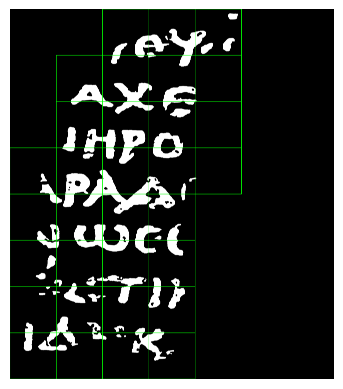

Cropping images - 2:   0%|          | 0/65 [00:00<?, ?it/s]

Merge images - 2:   0%|          | 0/103 [00:00<?, ?it/s]

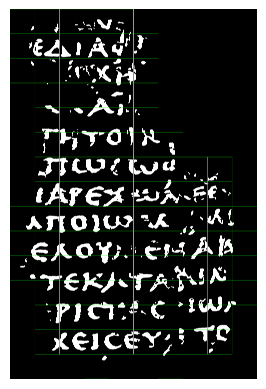

Cropping images - 3:   0%|          | 0/65 [00:00<?, ?it/s]

Merge images - 3:   0%|          | 0/31 [00:00<?, ?it/s]

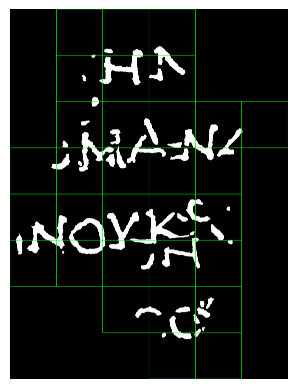

In [5]:
image_id_list_all = []
roi_id_list_all = []
x_pos_list_all = []
y_pos_list_all = []
for image_id in range(1, IMAGE_NUM+1):

    outputs = crop_image(image_id, INPUT_DIR, OUTPUT_DIR)

    image_id_list_all.extend(outputs["image_id_list"])
    roi_id_list_all.extend(outputs["roi_id_list"])
    x_pos_list_all.extend(outputs["x_pos_list"])
    y_pos_list_all.extend(outputs["y_pos_list"])

df = pd.DataFrame({
    "image_id": image_id_list_all,
    "roi_id": roi_id_list_all,
    "x_pos": x_pos_list_all,
    "y_pos": y_pos_list_all,
})
df.to_csv(str(OUTPUT_DIR / "train.csv"), index=False)

In [6]:
df = pd.read_csv(str(OUTPUT_DIR / "train.csv"))
df.head()

,image_id,roi_id,x_pos,y_pos
0,1,0,2048,0
1,1,1,3072,0
2,1,2,4096,0
3,1,3,1024,1024
4,1,4,2048,1024


In [14]:
#Loading required Libraries
import sklearn
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

#Reading Data output from the previous step
data = pd.read_csv(str(OUTPUT_DIR / "train.csv"))

#Splitting data into train and test
X = data[["x_pos", "y_pos"]]
y = data["roi_id"]

#Normalize Data
scaler = MinMaxScaler()
X_scaled = scaler.fit_transform(X)

#Splitting data into train and test
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, random_state=42)

In [15]:
#Creating our NN model
model = tf.keras.Sequential([
    tf.keras.layers.Dense(128, activation='relu', input_shape=(2,)),
    tf.keras.layers.Dense(64, activation='relu'),
    tf.keras.layers.Dense(1, activation='sigmoid')
])

#Compiling our model
model.compile(optimizer='adam',loss='binary_crossentropy', metrics=['accuracy'])

early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
checkpoint = ModelCheckpoint("best_weights.h5", monitor='val_loss', save_best_only=True)

#Training our model
history = model.fit(X_train, y_train, epochs=50, batch_size=32, validation_split=0.2, callbacks=[early_stopping, checkpoint])


Epoch 1/50
4/4 [==============================] - 1s 105ms/step - loss: -6.7405 - accuracy: 0.0190 - val_loss: -14.1340 - val_accuracy: 0.0370
Epoch 2/50
4/4 [==============================] - 0s 35ms/step - loss: -13.5863 - accuracy: 0.0095 - val_loss: -23.1300 - val_accuracy: 0.0370
Epoch 3/50
4/4 [==============================] - 0s 38ms/step - loss: -20.8055 - accuracy: 0.0095 - val_loss: -32.9208 - val_accuracy: 0.0370
Epoch 4/50
4/4 [==============================] - 0s 34ms/step - loss: -29.4428 - accuracy: 0.0095 - val_loss: -43.5152 - val_accuracy: 0.0370
Epoch 5/50
4/4 [==============================] - 0s 37ms/step - loss: -38.5311 - accuracy: 0.0095 - val_loss: -55.8300 - val_accuracy: 0.0370
Epoch 6/50
4/4 [==============================] - 0s 36ms/step - loss: -49.3460 - accuracy: 0.0095 - val_loss: -70.1263 - val_accuracy: 0.0370
Epoch 7/50
4/4 [==============================] - 0s 47ms/step - loss: -61.9724 - accuracy: 0.0095 - val_loss: -86.8511 - val_accuracy: 0.0370

In [16]:
#Evaluate our model
test_loss, test_accuracy = model.evaluate(X_test, y_test)
print(f"Test Loss: {test_loss}, Test Accuracy: {test_accuracy}")

2/2 [==============================] - 0s 6ms/step - loss: -11809.6729 - accuracy: 0.0294
Test Loss: -11809.6728515625, Test Accuracy: 0.029411764815449715


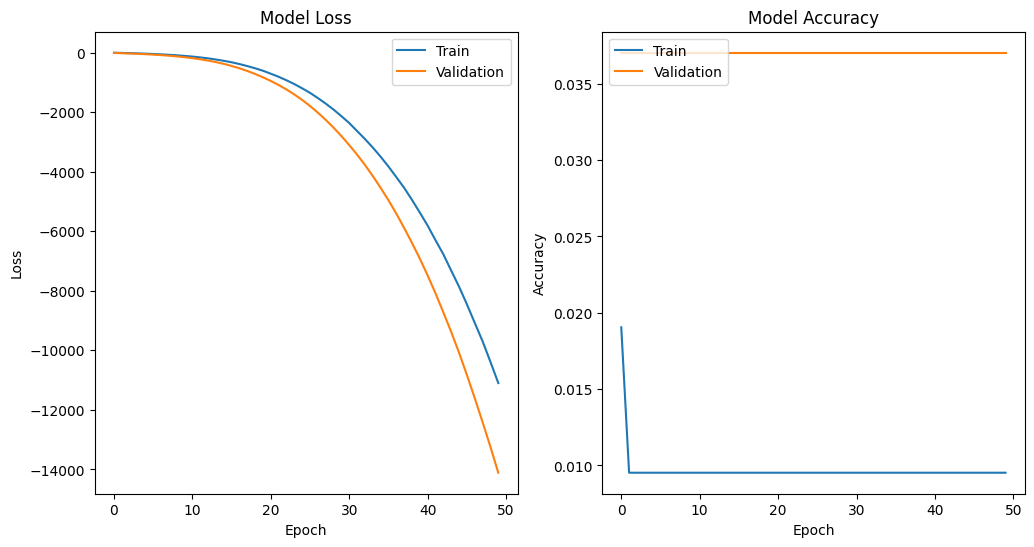

In [17]:
# Plot training & validation loss values
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper right')

# Plot training & validation accuracy values
plt.subplot(1, 2, 2)
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')

plt.show()